# Animal Classifier CNN

The following file will integrate a CNN aiming at using the `Animals-10` dataset in order to correctly classify them according to their species. Multiple different hyper parameters, transformations and models will be used through transfer learning to test out different configurations and determine which configuration leads to the best performance.

In order to maintain the code clean, the project will incorporate several helper functions, and will be modularized in the `utils` folder to keep the `main.ipynb` file as clean as possible.

Throughout the project, the structure can be seen in the outline where after setting up the foundations, the project will focus on tweaking parameters and assessing their performance through tensor board and our own manual prints.



## Data Setup

In [5]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[0]) >= 2, "torch version should be 2.+"
    assert int(torchvision.__version__.split(".")[1]) >= 15, "torchvision version should be 0.15+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not correct. Installing correct versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from tqdm.auto import tqdm
except:
    print(f"[INFO] Couldnt't find tqdm... installing it ")
    !pip install tqdm
    from tqdm.auto import tqdm


torch version: 2.2.2
torchvision version: 0.17.2


In [6]:
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] Couldn't find torchinfo... installing it")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    import splitfolders
except ImportError:
    print("[INFO] Installing splitfolders...")
    !pip install -q split-folders
    import splitfolders


try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter

try:
    from project_modules import data_setup, engine, get_data, model_builder, predictions, train, save_model, helper_functions
except ImportError:
    print("[INFO] Could not find project_modules scripts. Downloading them from GitHub.")
    !git clone https://github.com/Aaron-Serpilin/Animal-Classifier
    # Move both project modules and the data folder to the current directory
    !mv Animal-Classifier/project_modules .
    !mv Animal-Classifier/data .
    !rm -rf Animal-Classifier
    from project_modules import data_setup, engine, get_data, model_builder, predictions, train, save_model, helper_functions


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
from pathlib import Path

data_path = Path("data")
data_path

PosixPath('data')

In [8]:
import os

for dirpath, dirnames, filenames in os.walk(data_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 1 images in 'data'.
There are 10 directories and 0 images in 'data/test'.
There are 0 directories and 334 images in 'data/test/cat'.
There are 0 directories and 423 images in 'data/test/butterfly'.
There are 0 directories and 973 images in 'data/test/dog'.
There are 0 directories and 364 images in 'data/test/sheep'.
There are 0 directories and 965 images in 'data/test/spider'.
There are 0 directories and 620 images in 'data/test/chicken'.
There are 0 directories and 525 images in 'data/test/horse'.
There are 0 directories and 373 images in 'data/test/squirrel'.
There are 0 directories and 374 images in 'data/test/cow'.
There are 0 directories and 290 images in 'data/test/elephant'.
There are 10 directories and 1 images in 'data/raw-img'.
There are 0 directories and 1668 images in 'data/raw-img/cat'.
There are 0 directories and 2112 images in 'data/raw-img/butterfly'.
There are 0 directories and 4863 images in 'data/raw-img/dog'.
There are 0 directories and 1

In [9]:
train_dir = data_path / "train"
test_dir = data_path / "test"

train_dir, test_dir

(PosixPath('data/train'), PosixPath('data/test'))

## Visualizing Images

In [21]:
def set_seeds (seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [23]:
import random
from PIL import Image

# For recreatability purposes
random.seed(42)
set_seeds()

image_path_list = list(data_path.glob("*/*/*.jpg"))
image_path_list

[PosixPath('data/test/cat/ea36b40d2df2003ed1584d05fb1d4e9fe777ead218ac104497f5c978a7e8b7bc_640.jpg'),
 PosixPath('data/test/cat/ea37b90c20f0033ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eebdbb_640.jpg'),
 PosixPath('data/test/cat/ea37b40d2cf1083ed1584d05fb1d4e9fe777ead218ac104497f5c978a7ebb0bb_640.jpg'),
 PosixPath('data/test/cat/freddie-marriage-40645-unsplash.jpg'),
 PosixPath('data/test/cat/ea36b5082ff2093ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eebdbb_640.jpg'),
 PosixPath('data/test/cat/ea36b60f2cfd093ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eebdbb_640.jpg'),
 PosixPath('data/test/cat/ea36b60b20f2083ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eebdbb_640.jpg'),
 PosixPath('data/test/cat/ea35b70e2efc093ed1584d05fb1d4e9fe777ead218ac104497f5c978a7ebb0bb_640.jpg'),
 PosixPath('data/test/cat/pacto-visual-199601-unsplash.jpg'),
 PosixPath('data/test/cat/ea36b20f20f1033ed1584d05fb1d4e9fe777ead218ac104497f5c978a7e8b7bc_640.jpg'),
 PosixPath('data/test/cat/ea36b2092dfc013ed1584d05fb1d4e9

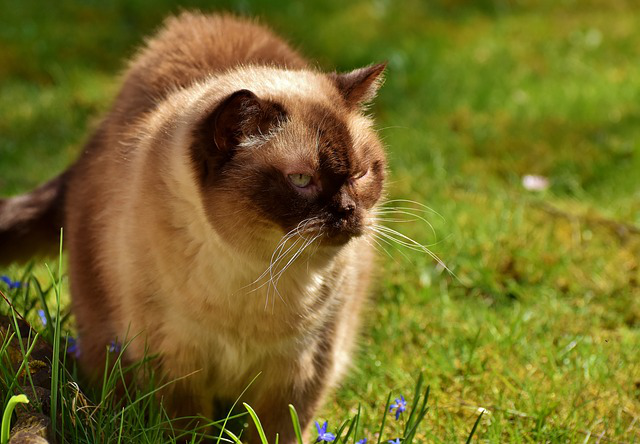

In [11]:
random_image_path = random.choice(image_path_list)
img = Image.open(random_image_path)
img

In [12]:
print(f"Image path: {random_image_path}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image class: {random_image_path.parent.stem}")

Image path: data/train/cat/ea37b8092bf5053ed1584d05fb1d4e9fe777ead218ac104497f5c978a7eebdbb_640.jpg
Image height: 444
Image width: 640
Image class: cat


## Preparing Data

In [13]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Preparing Transformations

In [14]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Lambda(lambda img: img + 0.02 * torch.randn_like(img)), # Noise injection
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

grayscale_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3)
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
     RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1))
     ToTensor()
     Lambda()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


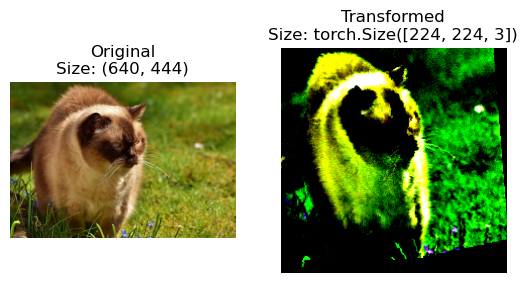

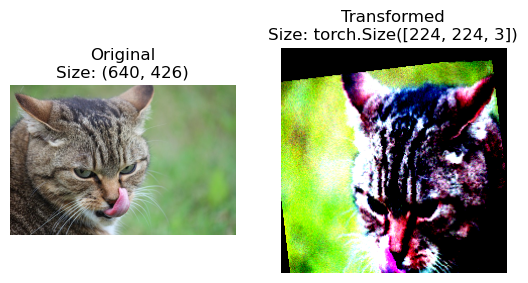

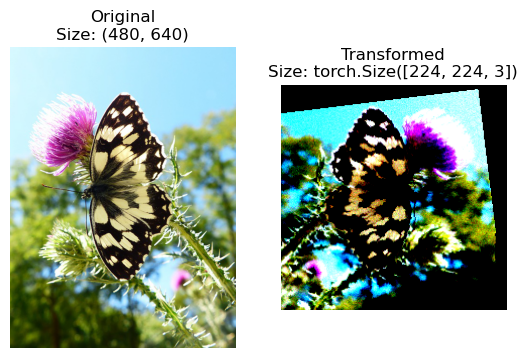

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

plot_transformed_images(image_path_list, train_transform)

### Preparing Image Folder, DataLoaders and Datasets

In [16]:
import os
from torch.utils.data import DataLoader
from project_modules.data_setup import create_dataloaders

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir,
    test_dir,
    train_transform,
    test_transform,
    BATCH_SIZE,
    NUM_WORKERS
    )

## Transfer Learning

The next section fetches the pre-trained models we aim to test. We then freeze their base layers and change the classifier head to match our problem. 

We freeze the layers to prevent the model to continue learning and updating the weights during training. This prevents backpropagation from taking place during training, and allows the weights to retain their value. This way we preserve the pre-trained knowledge, avoid overfitting, and reduce computational cost. 

To facilitate the development of the different models, we will use helper functions that do the following:
* Get the base model from `torchvision.models`
* Freeze the base layers
* Set the random seeds
* Change the classifier head
* Name the model

In [42]:
import torchvision
from torch import nn

def create_transfer_model(
        model, 
        model_name, 
        classifier_attr, 
        in_features, 
        out_features, 
        freeze_layer_attr=None, 
        dropout_rate=0.2, 
        device=device):
   
    if freeze_layer_attr is not None:
        base_layers = getattr(model, freeze_layer_attr, None)
        if base_layers is not None:
            for param in base_layers.parameters():
                param.requires_grad = False
        else:
            print(f"[WARNING] Model does not have attribute '{freeze_layer_attr}' to freeze.")
    
    set_seeds()
    
    new_classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_features, out_features)
    ).to(device)
    setattr(model, classifier_attr, new_classifier)
    
    model.name = model_name
    print(f"[INFO] Created new {model.name} model")
    return model



In [25]:
OUT_FEATURES = len(class_names)
OUT_FEATURES

11

Our dataset has 11 different classes, meaning that when redefining the classifier head, they will all share the `OUT_FEATURES` value. However, in order to determine the `in_features` we need to print out the summary of each model and find it.

Below will be defined all the different models we will use and track to determine which one has the best performance on our dataset, and to determine within the given model which preprocessing combination is the best.

In [32]:
import torchvision
from torchinfo import summary

effnetb0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
effnetb0_model = torchvision.models.efficientnet_b0(weights=effnetb0_weights).to(device)

effnetb3_weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
effnetb3_model = torchvision.models.efficientnet_b3(weights=effnetb3_weights)

resnet18_weights = torchvision.models.ResNet18_Weights.DEFAULT
resnet18_model = torchvision.models.resnet18(weights=resnet18_weights)

resnet34_weights = torchvision.models.ResNet34_Weights.DEFAULT
resnet34_model = torchvision.models.resnet34(weights=resnet34_weights)

# Older and more parameter heavy, but useful baseline
vgg13_weights = torchvision.models.VGG13_Weights.DEFAULT
vgg13_model = torchvision.models.vgg13(weights=vgg13_weights)

vgg16_weights = torchvision.models.VGG16_Weights.DEFAULT
vgg16_model = torchvision.models.vgg16(weights=vgg16_weights)


In [31]:
summary(model=effnetb0_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
        

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [33]:
summary(model=effnetb3_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1536, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 40, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 40, 112, 112]   1,080                True
│    │    └─BatchNorm2d (1)                                  [32, 40, 112, 112]   [32, 40, 112, 112]   80                   True
│    │    └─SiLU (2)                                         [32, 40, 112, 112]   [32, 40, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 40, 112, 112]   [32, 24, 112

In [34]:
summary(model=resnet18_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [35]:
summary(model=resnet34_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [36]:
summary(model=vgg13_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

In [37]:
summary(model=vgg16_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

In [43]:
effnetb0 = create_transfer_model(
    model=effnetb0_model,
    model_name="effnetb0",
    classifier_attr="classifier",  # EfficientNet uses 'classifier'
    in_features=1280,                
    out_features=OUT_FEATURES,
    freeze_layer_attr="features",    # Freeze the 'features' block
    dropout_rate=0.2,
    device=device
)

[INFO] Created new effnetb0 model


In [44]:
effnetb3 = create_transfer_model(
    model=effnetb3_model,
    model_name="effnetb3",
    classifier_attr="classifier",  
    in_features=1536,                
    out_features=OUT_FEATURES,
    freeze_layer_attr="features",   
    dropout_rate=0.2,
    device=device
)

[INFO] Created new effnetb3 model


In [50]:
resnet18 = create_transfer_model(
    model=resnet18_model,
    model_name="resnet18",
    classifier_attr="fc",  # ResNet uses 'fc' for its final classifier
    in_features=512,
    out_features=OUT_FEATURES,
    freeze_layer_attr=None,  # ResNet does not have a 'features' attribute to freeze
    dropout_rate=0.2,
    device=device
)

[INFO] Created new resnet18 model


In [49]:
resnet34 = create_transfer_model(
    model=resnet34_model,
    model_name="resnet34",
    classifier_attr="fc",  # ResNet uses 'fc'
    in_features=512,
    out_features=OUT_FEATURES,
    freeze_layer_attr=None,  # No 'features' attribute for ResNet
    dropout_rate=0.2,
    device=device
)

[INFO] Created new resnet34 model


In [ ]:
vgg13 = create_transfer_model(
    model=vgg13_model,
    model_name="vgg13",
    classifier_attr="classifier",  # VGG uses 'classifier'
    in_features=4096,               
    out_features=OUT_FEATURES,
    freeze_layer_attr="features",    # Freeze the 'features' block
    dropout_rate=0.2,
    device=device
)

[INFO] Created new vgg13 model


In [ ]:
vgg16 = create_transfer_model(
    model=vgg16_model,
    model_name="vgg16",
    classifier_attr="classifier",  
    in_features=4096,                
    out_features=OUT_FEATURES,
    freeze_layer_attr="features",    
    dropout_rate=0.2,
    device=device
)

[INFO] Created new vgg16 model


In [51]:
num_epochs = [5, 10]

models = ["effnetb0", "effnetb3", "resnet18", "resnet34", "vgg13" ,"vgg16"]

For Markdown tables, we use the following generator:
https://www.tablesgenerator.com/markdown_tables

## Model Tracking

In the following section we set up PyTorch's `torch.utils.tensorboard.SummaryWriter()` to save the multiple parts of the model's training progress. We can then compare said saved files to identify the best performing parameter combination. 

In [ ]:
writer = SummaryWriter()